In [68]:
import numpy as np
from scipy.signal import argrelextrema, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

Функции для загрузки сигналов и разметки классов.

In [37]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)

Папки с файлами рядов в обучающей и тестовой выборках.

In [45]:
INPUT_FOLDER_TRAIN = '../data/uci_har/train/InertialSignals/'
INPUT_FOLDER_TEST = '../data/uci_har/test/InertialSignals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

Загрузим данные

In [77]:
train_signals, test_signals = [], []
 
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)

test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

LABELFILE_TRAIN = '../data/uci_har/train/y_train.txt'
LABELFILE_TEST = '../data/uci_har/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

В качестве начального варианта признаков возьмем среднее значение, медиану, минимум и максимум (для каждого канала, коих 9).

In [78]:
def extract_features(dataset):
    mean = np.mean(dataset, axis=1)
    median = np.median(dataset, axis=1)
    minimum = np.min(dataset, axis=1)
    maximum = np.max(dataset, axis=1)
    features = np.hstack((mean, median, minimum, maximum))
    return features

Вытащим признаки, получив стандартную таблицу строка (объект) - столбец (признак).

In [79]:
train_features = extract_features(train_signals)
test_features = extract_features(test_signals)

Отнормируем признаки в отрезок от 0 до 1.

In [80]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)

Перед обучением модели посмотрим на баланс классов в обучающей и тестовой выборках.

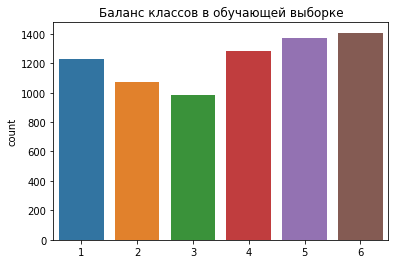

In [87]:
sns.countplot(train_labels)
plt.title('Баланс классов в обучающей выборке');

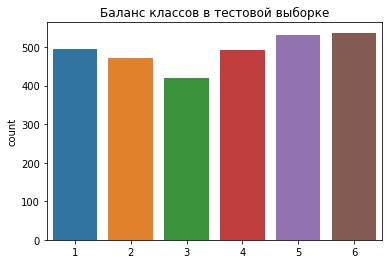

In [88]:
sns.countplot(test_labels)
plt.title('Баланс классов в тестовой выборке');

Видим, что выборки неплохо сбалансированы, поэтому наивным подходом можно получить где-то 1/6 (примерно 17% правильных ответов). Будем отталкиваться от этого значения.

Обучим метод опорных векторов, проверим процент правильных ответов на обучающей и на тестовой выборках.

In [89]:
clf = SVC(kernel='rbf', C=0.1)
clf.fit(X_train, train_labels)

y_train_pred = clf.predict(X_train)
accuracy_score(train_labels, y_train_pred)

0.905739934711643

In [90]:
y_test_pred = clf.predict(X_test)
accuracy_score(test_labels, y_test_pred)

0.8585001696640652

С помощью метода опорных векторов получили 85% правильных ответов на тестовой выборке без подбора гиперпараметров.